In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from config import *
from functions import *
from sim import *
from read_ramses import *
from scipy.interpolate import interp1d
from scipy.special import erfinv
import const


### feedback model

In [40]:
dx = 10 * const.pc
n_H = 100
metallicity = const.Z_sol

def fbk_ramses(n_H, metallicity, dx):

    r_cool = 3 * const.pc * (metallicity / const.Z_sol)**(-0.082) * (n_H / 100)**(-0.42)
    mom_SN = 1.42e5 * const.km * const.M_sol * (metallicity / const.Z_sol)**(-0.137) * (n_H / 100)**(-0.16)
    mom = mom_SN * np.minimum(1, (dx / r_cool)**(3/2)) * (r_cool < 4 * dx)
    return mom

def fbk_martizzi(n_H, metallicity, dx):
    
    alpha = -11 * (metallicity / const.Z_sol)**(0.07) * (n_H / 100)**(0.114)
    r_cool = 6.3 * const.pc * (metallicity / const.Z_sol)**(-0.05) * (n_H / 100)**(-0.42)
    r_thm = 9.2 * const.pc * (metallicity / const.Z_sol)**(-0.067) * (n_H / 100)**(-0.44)
    r0 = 2.4 * const.pc * (metallicity / const.Z_sol)**(0.021) * (n_H / 100)**(-0.35)
    r_mom = 8 * const.pc * (metallicity / const.Z_sol)**(-0.058) * (n_H / 100)**(-0.46)
    
    energy_SN = 1e51
    mom_SN = 1.42e5 * const.km * const.M_sol
    
    energy = energy_SN * ((r_cool - dx) + (dx / r_cool)**alpha * (dx > r_cool) * (r_thm > dx) + (r_thm / r_cool)**alpha * (r > r_thm))
    mom = mom_SN * ((dx / r0)**1.5 * (r_mom > dx) + (r_mom / r0) * (dx > r_mom))
    
    return energy, mom


### massive star mass fraction

In [45]:
def kroupa(m):
    imf = np.zeros_like(m)
    imf[m < 0.08] = 25 * m[m < 0.08]**(-0.3)
    imf[(m > 0.08) * (m < 0.5)] = 2 * m[(m > 0.08) * (m < 0.5)]**(-1.3)
    imf[(m > 0.5) * (m < 1.0)] = m[(m > 0.5) * (m < 1.0)]**(-2.3)
    imf[m > 1.0] = m[m > 1.0]**(-3.7)
    return imf

m = np.logspace(-2, 1)
imf = kroupa(m)


In [46]:
m_SNe = 8 # mass above which Type II SNe occur

kroupa_norm = 25 / (-0.3 + 2) * 0.08**(-0.3 + 2) \
    + 2 / (-1.3 + 2) * (0.5**(-1.3 + 2) - 0.08**(-1.3 + 2)) \
    + 1 / (-2.3 + 2) * (1.0**(-2.3 + 2) - 0.5**(-2.3 + 2)) \
    + -1 / (-2.7 + 2) * 1.0**(-2.7 + 2) # integral of the Kroupa IMF
kroupa_SNe = -1 / (-2.7 + 2) * m_SNe**(-2.7 + 2) # integral of the Kroupa IMF above m_SNe
eps_SNe = kroupa_SNe / kroupa_norm # mass fraction of stars that go SNe

eps_SNe


0.0907728971746926

### multi-freefall

/tmp/ipykernel_776643/284124865.py:12: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(alpha_vir, mach_turb, np.log10(epsilon_SF), levels=[-3, -2, -1, 0, 1])


Text(0, 0.5, '$\\mathcal{M}_{\\rm turb}$')

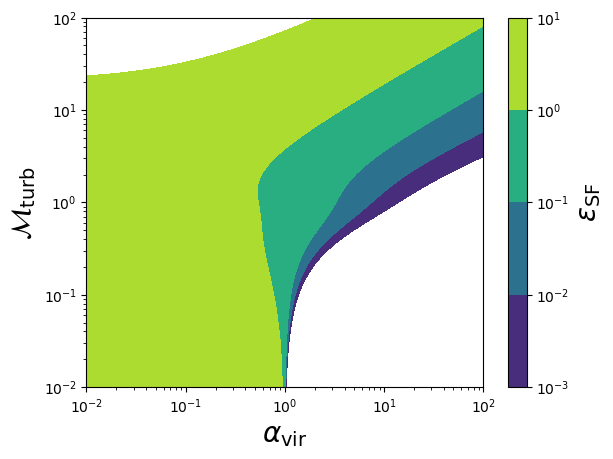

In [6]:
alpha_vir_extrema = (1e-2, 1e2)
mach_turb_extrema = (1e-2, 1e2)
num = 300
b_turb = 1.0

alpha_vir_1d = np.logspace(*np.log10(alpha_vir_extrema), num)
mach_turb_1d = np.logspace(*np.log10(mach_turb_extrema), num)
alpha_vir, mach_turb = np.meshgrid(alpha_vir_1d, mach_turb_1d, indexing='ij')
epsilon_SF = calc_eps_sf(alpha_vir, mach_turb, b_turb=b_turb)
rho_norm = (1 + mach_turb**2) / alpha_vir

im = plt.contourf(alpha_vir, mach_turb, np.log10(epsilon_SF), levels=[-3, -2, -1, 0, 1])

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$\alpha_{\rm vir}$", fontsize=20)
plt.ylabel(r"$\mathcal{M}_{\rm turb}$", fontsize=20)

# save_fig("SFE-alpha-mach")


/tmp/ipykernel_397939/2042395721.py:15: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])


Text(0.5, 1.0, '$b_{\\rm turb} = 1$')

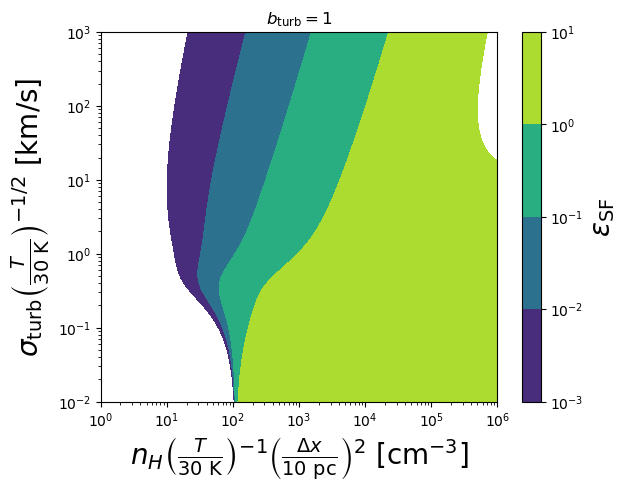

In [51]:
num = 1000
temp = 30
dx = 10 * const.pc
b_turb = 1.0

n_H_extrema = (1e0, 1e6)
vel_turb_extrema = (1e-2 * const.km, 1e3 * const.km)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
vel_turb_1d = np.logspace(*np.log10(vel_turb_extrema), num)
n_H, vel_turb = np.meshgrid(n_H_1d, vel_turb_1d, indexing='ij')
rho = n_H * const.m_p
eps_sf = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)

im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$b_{\rm turb} = %.2g$' % b_turb)

#save_fig("bturb0p3")



In [ ]:
num = 1000
temp = 30
dx = 10 * const.pc
b_turb = 1.0

n_H_extrema = (1e0, 1e6)
vel_turb_extrema = (1e-2 * const.km, 1e3 * const.km)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
vel_turb_1d = np.logspace(*np.log10(vel_turb_extrema), num)
n_H, vel_turb = np.meshgrid(n_H_1d, vel_turb_1d, indexing='ij')
rho = n_H * const.m_p
eps_sf = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)

im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$b_{\rm turb} = %.2g$' % b_turb)

#save_fig("bturb0p3")



/tmp/ipykernel_397939/1875624377.py:19: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])
/tmp/ipykernel_397939/1875624377.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf_fiducial), levels=[-3, -2, -1, 0, 1], alpha=0.2)


Text(0.5, 1.0, '$m_* = 3000 M_\\odot$')

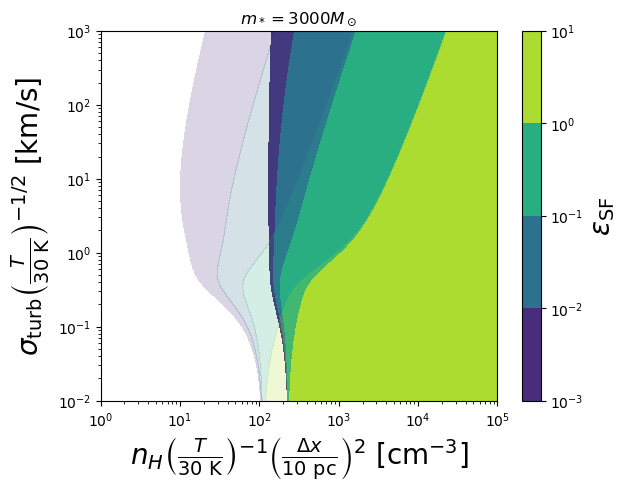

In [70]:
num = 1000
temp = 30
dx = 10 * const.pc
b_turb = 1.0
m_star = 3000 * const.M_sol

n_H_extrema = (1e0, 1e5)
vel_turb_extrema = (1e-2 * const.km, 1e3 * const.km)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
vel_turb_1d = np.logspace(*np.log10(vel_turb_extrema), num)
n_H, vel_turb = np.meshgrid(n_H_1d, vel_turb_1d, indexing='ij')
rho = n_H * const.m_p
epsilon_SF = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)

eps_sf_fiducial = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)
eps_sf = calc_eps_sf2(rho - m_star/dx**3, 3/2*vel_turb**2, temp, dx=dx, b_turb=b_turb)

im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])
plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf_fiducial), levels=[-3, -2, -1, 0, 1], alpha=0.2)

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$m_* = %d M_\odot$' % (m_star / const.M_sol))

#save_fig("epssf_mstar15000")



/tmp/ipykernel_397939/3034852600.py:23: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])
/tmp/ipykernel_397939/3034852600.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf_fiducial), levels=[-3, -2, -1, 0, 1], alpha=0.2)


Text(0.5, 1.0, '$m_* = 3000 M_\\odot$ vs $m_* = 15000 M_\\odot$')

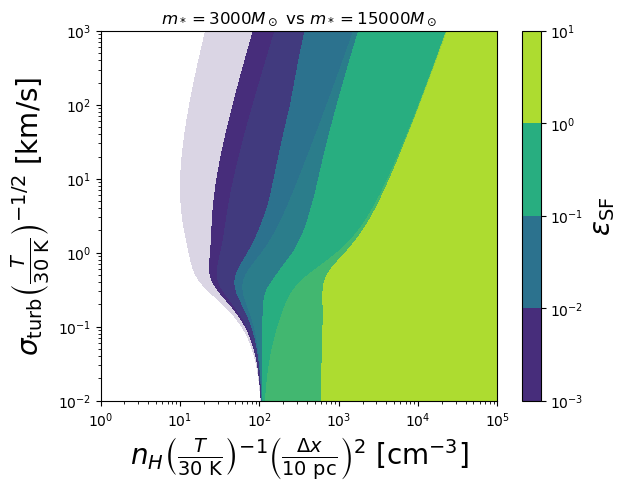

In [102]:
num = 1000
temp = 30
dx = 10 * const.pc
b_turb = 1.0
m_star = 3000 * const.M_sol
m_star_fiducial = 15000 * const.M_sol

n_H_extrema = (1e0, 1e5)
vel_turb_extrema = (1e-2 * const.km, 1e3 * const.km)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
vel_turb_1d = np.logspace(*np.log10(vel_turb_extrema), num)
n_H, vel_turb = np.meshgrid(n_H_1d, vel_turb_1d, indexing='ij')
rho = n_H * const.m_p
epsilon_SF = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)

eps_sf_fiducial = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)
eps_sf = np.zeros_like(eps_sf_fiducial)
for i in range(0, int(m_star_fiducial/m_star)):
    eps_sf += np.nan_to_num(calc_eps_sf2(rho - i*m_star/dx**3, 3/2*vel_turb**2, temp, dx=dx, b_turb=b_turb))
eps_sf /= int(m_star_fiducial/m_star)

im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])
plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf_fiducial), levels=[-3, -2, -1, 0, 1], alpha=0.2)

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$m_* = %d M_\odot$ vs $m_* = %d M_\odot$' % (m_star / const.M_sol, m_star_fiducial / const.M_sol))

#save_fig("epssf_mstar_comp2")



/tmp/ipykernel_397939/1958851675.py:1: RuntimeWarning: invalid value encountered in divide
  im = plt.contourf(n_H, vel_turb / const.km, eps_sf / eps_sf_fiducial, levels=np.linspace(0, 1, 200), cmap='jet')
/tmp/ipykernel_397939/1958851675.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.contour(n_H, vel_turb / const.km, np.log10(eps_sf_fiducial), levels=[-3, -2, -1, 0, 1], colors='black', linestyles='-')


Saved figure as 'epssf_ratio_comp2-021220241305.png'


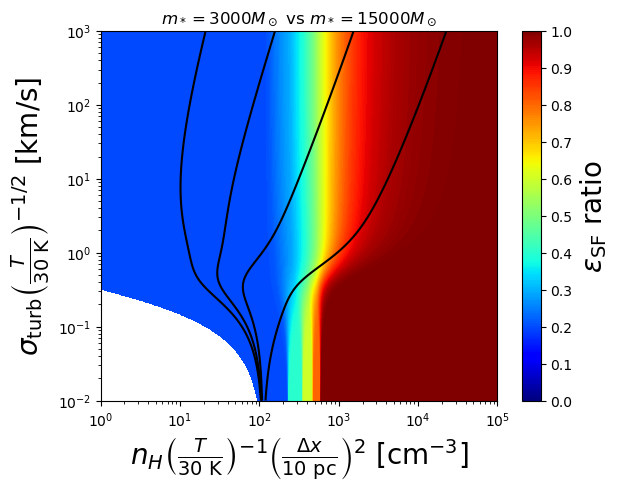

In [103]:
im = plt.contourf(n_H, vel_turb / const.km, eps_sf / eps_sf_fiducial, levels=np.linspace(0, 1, 200), cmap='jet')
plt.contour(n_H, vel_turb / const.km, np.log10(eps_sf_fiducial), levels=[-3, -2, -1, 0, 1], colors='black', linestyles='-')

plt.xscale('log')
plt.yscale('log')
plt.colorbar(im, ticks=np.arange(0, 1.1, 0.1)).set_label(r"$\varepsilon_{\rm SF}$ ratio", fontsize=20)

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$m_* = %d M_\odot$ vs $m_* = %d M_\odot$' % (m_star / const.M_sol, m_star_fiducial / const.M_sol))

save_fig("epssf_ratio_comp2")


In [217]:
temp = 30
dx = 10*const.pc
b_turb = 1.0
mach = 500
c_s = np.sqrt(const.k_B * temp / const.m_p)
rho = 1e-20

sigma_s = np.sqrt(np.log(1 + b_turb**2 * mach**2))
c_s = np.sqrt(const.k_B * temp / const.m_p)
alpha_vir = 15 / np.pi * 2 * c_s**2 * (1 + mach**2) / (const.G * rho * dx**2)
s_min = np.log(alpha_vir * 2 * mach**4 / (1 + mach**2))
s_max = np.sqrt(2 * sigma_s**2) * erfinv(1 - 2 / mach**6) + sigma_s**2

s_min, s_max

(22.260481751871627, 41.664021430801064)

/tmp/ipykernel_397939/3815413032.py:24: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])


Text(0.5, 1.0, '$b_{\\rm turb} = 1$')

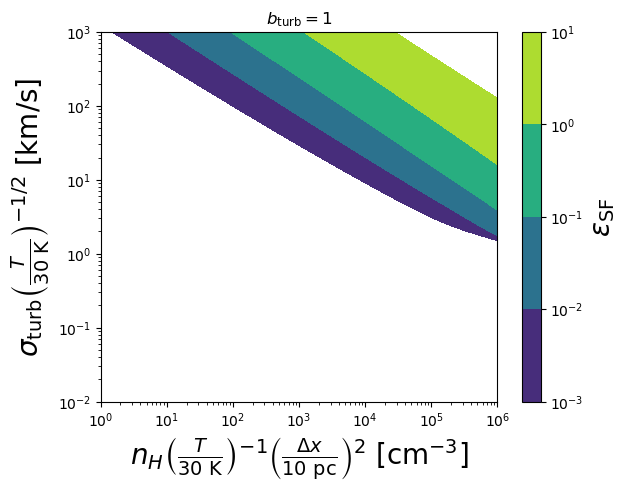

In [218]:
num = 1000
temp = 30
dx = 10*const.pc
b_turb = 1.0

n_H_extrema = (1e0, 1e6)
vel_turb_extrema = (1e-2 * const.km, 1e3 * const.km)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
vel_turb_1d = np.logspace(*np.log10(vel_turb_extrema), num)
n_H, vel_turb = np.meshgrid(n_H_1d, vel_turb_1d, indexing='ij')

rho = n_H*const.m_p
energy_turb = 3/2*vel_turb**2
alpha_vir = 15 / np.pi * 2 * c_s**2 * (1 + mach**2) / (const.G * rho * dx**2)
c_s = np.sqrt(const.k_B * temp / const.m_p)
mach = vel_turb / c_s
sigma_s = np.sqrt(np.log(1 + b_turb**2 * mach**2))
s_min = np.log(alpha_vir * 2 * mach**4 / (1 + mach**2))
s_max = np.sqrt(2 * sigma_s**2) * erfinv(1 - 2 / mach**6) + sigma_s**2
eps_sf = np.exp(3/8*sigma_s**2) * (erf((sigma_s**2 - s_min) / (np.sqrt(2*sigma_s**2))) - erf((sigma_s**2 - s_max) / (np.sqrt(2*sigma_s**2))))
eps_sf[eps_sf < 0] = 0.

im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$b_{\rm turb} = %.2g$' % b_turb)

#save_fig("eps_sf_attempt")


### timescales

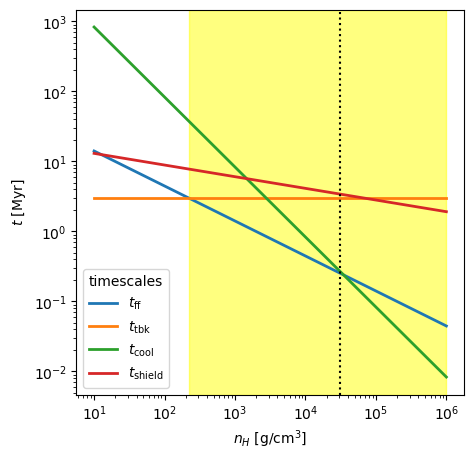

In [246]:
num = 100
metallicity = 1/3 * const.Z_sol
temp = 10**4
C = 1

M_cl = 10**6 * const.M_sol
V_w = 10**3.5 * const.km
R_gal = 1 * const.kpc
M_gen = 10**9 * const.M_sol
t_fbk0 = 3 * const.Myr

n_H_min, n_H_max = 10, 10**(6)
n_H = np.logspace(np.log10(n_H_min), np.log10(n_H_max), num) # Hydrogen number density
rho = n_H * const.m_H / const.X_cosmo
t_ff = np.sqrt(3 * np.pi / (32 * const.G * rho))
t_fbk = np.full_like(rho, t_fbk0)
t_cool = 0.87 * const.Myr * (n_H / 10**3.5)**(-1) * (metallicity / const.Z_sol)**(-1) * (temp / 10**4) * np.exp(0.009 * (temp / 10**4)**(-1)) * C**(-1)
# t_sh = 5 * const.Myr * (n_H / 10**3.5)**(-1/6) * (M_cl / (10**6 * const.M_sol))**(1/3) * (V_w / (10**3.5 * const.km))**(-1/2) * (R_gal / const.kpc) * (M_gen / (10**9 * const.M_sol))**(-1/2)
n_cool = 3.4e3 * (metallicity / const.Z_sol)**(-2) * (temp / 10**4)**2 * C**(-2)
n_ffb = const.X_cosmo * 3*np.pi/(32*const.G*t_fbk0**2) / const.m_H

plt.figure(figsize=(5, 5))

plt.plot(n_H, t_ff / const.Myr, lw=2, label=r'$t_{\rm ff}$')
plt.plot(n_H, t_fbk / const.Myr, lw=2, label=r'$t_{\rm tbk}$')
plt.plot(n_H, t_cool / const.Myr, lw=2, label=r'$t_{\rm cool}$')
plt.plot(n_H, t_sh / const.Myr, lw=2, label=r'$t_{\rm shield}$')
plt.axvline(x=n_cool, color='black', linestyle=':')
plt.axvspan(n_ffb, n_H_max, color='yellow', alpha=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n_H$ [${\rm g/cm^3}$]')
plt.ylabel(r'$t$ [${\rm Myr}$]')
plt.legend(title='timescales')


In [ ]:
n_min, n_max = 10, 10**(6)
temp_min, temp_max = 1, 1e4



Saved figure as 'mstartemp-013120241236.png'


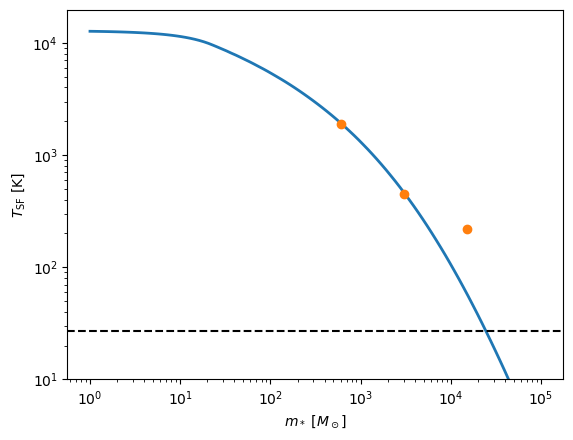

In [90]:
m_star = np.logspace(0, 5, 100) * const.M_sol
time_starform = 0.1*const.Myr
dt = 500*const.yr
rho_starform = 1e-20
energy_turb_starform = 1e13
dx = 10*const.pc

num_tstep = time_starform / dt
m_gas = -m_star * np.log(1 - 0.5) / num_tstep
t_ff_starform = np.sqrt(3 * np.pi / (32 * const.G * rho_starform))
eps_sf = m_gas / dx**3 / dt / rho_starform * t_ff_starform

temp = np.logspace(1, 4, 100)
eps_sf_interp = interp1d(calc_eps_sf2(rho_starform, energy_turb_starform, temp, dx), temp, fill_value='extrapolate')

plt.plot(m_star / const.M_sol, eps_sf_interp(eps_sf), lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_*$ [$M_\odot$]')
plt.ylabel(r'$T_{\rm SF}$ [${\rm K}$]')
plt.axhline(y=27, color='black', linestyle='--')

plt.plot([600, 3000, 15000], [1890, 446, 218], 'o')
plt.ylim(10)

save_fig('mstartemp')
